In [9]:
from src.filter_lib.image_filter_lib import ImageFilter
from keras.layers import *
import sys
import argparse
import cv2
import time 
import os
import matplotlib.pyplot as plt
%matplotlib inline
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
 
# 模型初始化
model_path = '/Users/zy/Desktop/tem_image_filter/models'
face_detect_model_path = os.path.join(model_path, 'detect_model')
clothes_detect_model_path = os.path.join(
    model_path, 'eland_detect_v3.h5')
clothes_recognitize_model_path = os.path.join(
    model_path, 'recognition_model_v14_test3.h5')
complexion_model_path = os.path.join(model_path, 'complexion_model_v1.h5')
tone_model_path = os.path.join(model_path, 'tone_model.pkl')
text_model_path = os.path.join(model_path, 'text_classify_v1.h5')
uselessDetectClothesLabels = ['帽子', '鞋靴', '包']
uselessRecognitionClothesLabels = ['泳装-内衣', '内裤-泳裤']

imagefilter = ImageFilter(face_detect_model_path=face_detect_model_path, clothes_detect_model_path=clothes_detect_model_path, 
                          complexion_model_path=complexion_model_path,text_model_path = text_model_path, resolution_threshold=260, brightness_threshold = 78, min_side_threshold=720)



ValueError: Variable pnet/conv1/weights already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/Users/zy/Desktop/tem_image_filter/src/detect_all_lib/face_detection.py", line 180, in make_var
    return tf.get_variable(name, shape, trainable=self.trainable)
  File "/Users/zy/Desktop/tem_image_filter/src/detect_all_lib/face_detection.py", line 193, in conv
    kernel = self.make_var('weights', shape=[k_h, k_w, c_i // group, c_o])
  File "/Users/zy/Desktop/tem_image_filter/src/detect_all_lib/face_detection.py", line 129, in layer_decorated
    layer_output = op(self, layer_input, *args, **kwargs)


In [10]:
from src.recognition_lib.category_efficient_recognition import Efficient_Recognition
# 品类识别模型
clothes_recognition_model = Efficient_Recognition(not_predict_labels=uselessDetectClothesLabels, modelPath=clothes_recognitize_model_path)



def test_src(img):
    uselessDetectClothesLabels = ['帽子', '鞋靴', '包']
    uselessRecognitionClothesLabels = ['泳装-内衣', '内裤-泳裤', '礼服']
    img_h,img_w, _ = img.shape
    print('[IMGINFO] img shape is {}'.format(img.shape))
    face_position_list, clothes_position_list = [], []
    min_side_result = imagefilter.cal_img_min_side(img)
    resolution_results = imagefilter.cal_img_resolution(img)
    brightness_result = imagefilter.cal_img_brightness(img)
    face_num, face_positions, landmarks = imagefilter.get_face_positions(img)
    clothes_detect_results = imagefilter.get_clothes_category_positions(img)
    
    print('[IMGINFO] image resolution is {}, resolution threshold is 260'.format(resolution_results))
    print('[IMGINFO] image  brihtness is {}, brightness threshold is 78 '.format(brightness_result))
    print('[FACEINFO] face num is {}, face positioin is {}'.format(face_num, face_positions))
    
    if face_num !=0:
        face_position_list = []
        face_complexion_labels =  imagefilter.get_face_complexion(img,face_num,landmarks)
        print('[FACEINFO] face complexion list are: {}'.format(face_complexion_labels))
        for i in range(face_num):
            xmin, ymin,xmax, ymax = face_positions[i]['xmin'], face_positions[i]['ymin'], face_positions[i]['xmax'], face_positions[i]['ymax']
            face_position_list.append([float(xmin), float(ymin), float(xmax), float(ymax)])
            print('[FACEINFO] face_h:{}'.format(float(ymax)-float(ymin)))

    print('[CLOTHESINFO] clothes num is {}, clothes results are: {}'.format(len(clothes_detect_results), clothes_detect_results))
    level_one_labels = []
    if len(clothes_detect_results) !=0:
        for clothes_detect_dict in clothes_detect_results:
            label = clothes_detect_dict['label']
            # 鞋靴，帽子，包 等标签不进行服装面积阈值设定
            if label in uselessDetectClothesLabels:
                continue
            level_one_labels.append(label)
            xmin, ymin, xmax, ymax = max(0, float(clothes_detect_dict['xmin'])), max(0, float(
                clothes_detect_dict['ymin'])), min(1, float(clothes_detect_dict['xmax'])), min(1, float(clothes_detect_dict['ymax']))
            clothes_h, clothes_w = ymax - ymin, xmax - xmin
            print('[CLOTHESINFO] clothes_h: {}, clothes_w:{}'.format(clothes_h, clothes_w))
            clothes_position_list.append([xmin, ymin, xmax, ymax])
        clothes_category_list= clothes_recognition_model.recognition(img, clothes_detect_results)
        print('[CLOTHESINFO] clothes_category_list: {}'.format(clothes_category_list))

        
    text_result = imagefilter.get_img_text(img)
    print('[INFO] the image text result is {}'.format(text_result))
    
    if len(face_position_list) != 0:
        for face_position in face_position_list:
            cv2.rectangle(img, (int(face_position[0]*img_w), int(face_position[1]*img_h)), (int(face_position[2]*img_w), int(face_position[3]*img_h)), (0,0,255), 10)
    if len(clothes_position_list) != 0:
        for clothes_position in clothes_position_list:
            cv2.rectangle(img, (int(clothes_position[0]*img_w), int(clothes_position[1]*img_h)), (int(clothes_position[2]*img_w), int(clothes_position[3]*img_h)), (0,255,0), 10)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    

[IMGINFO] img shape is (1347, 1080, 3)
img_h:1347  img_w:1080
laeblList : [{'label': '上衣', 'xmin': '0.182', 'ymin': '0.661', 'xmax': '0.823', 'ymax': '0.994', 'score': '0.478'}]
[IMGINFO] image resolution is (False, 201.4601717554724, 260), resolution threshold is 260
[IMGINFO] image  brihtness is ('norm', ''), brightness threshold is 78 
[FACEINFO] face num is 1, face positioin is [{'xmin': 0.361, 'ymin': 0.097, 'xmax': 0.654, 'ymax': 0.424}]
[FACEINFO] face complexion list are: ['not_black']
[FACEINFO] face_h:0.32699999999999996
[CLOTHESINFO] clothes num is 1, clothes results are: [{'label': '上衣', 'xmin': '0.182', 'ymin': '0.661', 'xmax': '0.823', 'ymax': '0.994', 'score': '0.478'}]
[CLOTHESINFO] clothes_h: 0.33299999999999996, clothes_w:0.641
[CLOTHESINFO] clothes_category_list: [['半身裙', 0.6800279]]
[INFO] the image text result is norm


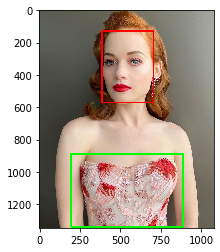

In [12]:
# url 读取
import numpy as np
from urllib.request import urlopen

url_list = ['https://zhiyi-image.oss-cn-hangzhou.aliyuncs.com/data_infra/18/9c80f2f538b6f3865f01d1b144495894_3611339e773f009fc2e77015fbd318a2.jpg',
'https://zhiyi-image.oss-cn-hangzhou.aliyuncs.com/data_infra/18/de10e970e922439e58b9a50a84e964f5_36de5d532743181a05e9c4836de961d0.jpg',
'https://zhiyi-image.oss-cn-hangzhou.aliyuncs.com/data_infra/18/c62b6adbcf44f8d41248ba546808f7ea_b4250b0c92609eb8e90c66fe060d2d19.jpg',
'https://zhiyi-image.oss-cn-hangzhou.aliyuncs.com/data_infra/18/4ccb6fe024b7da0bef0a6b8487a8766a_0d7aebb81f2c7a304cc468f7c33c73ca.jpg',
'https://zhiyi-image.oss-cn-hangzhou.aliyuncs.com/data_infra/18/83acd1513536e1b19349ce4e111ab174_ee8f4255c1073ce6c5d81ad7918a2763.jpg',
'https://zhiyi-image.oss-cn-hangzhou.aliyuncs.com/data_infra/18/bab20a50d510fda1d4e96e15ba833428_79a352339d73048f979f810c9645adb9.jpg',
'https://zhiyi-image.oss-cn-hangzhou.aliyuncs.com/data_infra/18/45068e4f24a1793292616acbb48d1b48_d48cccf2a2018fa3321f94e82c1a8f27.jpg',
'https://zhiyi-image.oss-cn-hangzhou.aliyuncs.com/data_infra/18/c40d0a6c5362b477c344925038b6d494_96763bde97b71ba58778b968cbd9a594.jpg',
'https://zhiyi-image.oss-cn-hangzhou.aliyuncs.com/data_infra/18/e8d8c1eb73289b5f03b3d3e5bae70d08_480c16dab74ab9f06293798a30ad1884.jpg',
'https://zhiyi-image.oss-cn-hangzhou.aliyuncs.com/data_infra/18/1c0999752537e05329730a575e3f37cc_b2c3575e6ee090e17b394c5461fda84d.jpg',
'https://zhiyi-image.oss-cn-hangzhou.aliyuncs.com/data_infra/18/5592951bca3f97be5c2367f8fc7ebee0_fc9f748b57485d103d543ccd999cea9e.jpg',
'https://zhiyi-image.oss-cn-hangzhou.aliyuncs.com/data_infra/18/c774270fc5397266747941d7523383cb_6faf6d95d8db41e9835cad60476ea41b.jpg']

def read_from_url(url):
    request = urlopen(url)
    img_array = np.asarray(bytearray(request.read()), dtype=np.uint8)
    return cv2.imdecode(img_array, cv2.IMREAD_COLOR)

url = 'https://zhiyi-image.oss-cn-hangzhou.aliyuncs.com/data-infra/20/bc26e6fd1c547b96df4e6815c778e581_98b9c320586028c5856899e04910d94d.jpg'
url = 'https://zhiyi-image.oss-cn-hangzhou.aliyuncs.com/data_infra/18/024af8344e6b89bc7d042883c842d5e7_797e1159f3849ccace09c2460779d43c.jpg'
img = read_from_url(url)
test_src(img)



In [13]:
# 本地图像文件读取
import numpy as np
import glob

img_path= 'image/00170517de1f80cb05cab3b3ac0d1101.jpg'
img = cv2.imread(img_path)
test_src(img)

AttributeError: 'NoneType' object has no attribute 'shape'